# 04 - Implementação de Graph Neural Networks

Este notebook implementa e treina GNNs para análise de posições de xadrez.

## Objetivos
1. Implementar modelos GNN com PyTorch Geometric
2. Treinar modelos para classificação de posições
3. Avaliar performance dos modelos
4. Visualizar resultados e interpretabilidade

## Modelos Implementados
- **GCN**: Graph Convolutional Network
- **GAT**: Graph Attention Network
- **GraphSAGE**: Graph Sample and Aggregate
- **ChessGNN**: Modelo customizado para xadrez

## Importações e Configurações


In [13]:
# Importações necessárias
import sys
import os
sys.path.append('../src')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import pickle
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
from collections import Counter
warnings.filterwarnings('ignore')

from data import ChessGraph

# Configuração de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Bibliotecas importadas com sucesso!")
print(f"PyTorch version: {torch.__version__}")

# Configurações
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {DEVICE}")

# Carregar dados processados
def load_processed_data(filename='constructed_graphs.pkl'):
    """Carrega grafos processados"""
    try:
        with open(f'../data/{filename}', 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Arquivo {filename} não encontrado. Execute primeiro os notebooks anteriores.")
        return None

# Carregar grafos
chess_graphs = load_processed_data()
if chess_graphs:
    print(f"Grafos carregados:")
    for graph_type, graphs in chess_graphs.items():
        print(f"  {graph_type}: {len(graphs)} grafos")
else:
    print("Grafos não encontrados. Criando dados de exemplo...")
    # Criar dados de exemplo
    chess_graphs = {
        'attack': [],
        'defense': [],
        'movement': [],
        'hybrid': []
    }


Bibliotecas importadas com sucesso!
PyTorch version: 2.6.0+cpu-cxx11-abi
Dispositivo: cpu
Grafos carregados:
  attack: 1500 grafos
  defense: 1500 grafos
  movement: 1500 grafos
  hybrid: 1500 grafos


In [14]:
# Implementação dos Modelos GNN
class ChessGCN(nn.Module):
    """Graph Convolutional Network para xadrez"""
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, dropout=0.5):
        super(ChessGCN, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Camadas GCN
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))
        
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        
        self.convs.append(GCNConv(hidden_dim, hidden_dim))
        
        # Classificador
        self.classifier = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, edge_index, batch):
        # Aplicar camadas GCN
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Pooling global
        x = global_mean_pool(x, batch)
        
        # Classificação
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

class ChessGAT(nn.Module):
    """Graph Attention Network para xadrez"""
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4, num_layers=3, dropout=0.5):
        super(ChessGAT, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Camadas GAT
        self.convs = nn.ModuleList()
        self.convs.append(GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout))
        
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, dropout=dropout))
        
        self.convs.append(GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout))
        
        # Classificador
        self.classifier = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, edge_index, batch):
        # Aplicar camadas GAT
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Pooling global
        x = global_mean_pool(x, batch)
        
        # Classificação
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

class ChessSAGE(nn.Module):
    """GraphSAGE para xadrez"""
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, dropout=0.5):
        super(ChessSAGE, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Camadas SAGE
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(input_dim, hidden_dim))
        
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
        
        self.convs.append(SAGEConv(hidden_dim, hidden_dim))
        
        # Classificador
        self.classifier = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, edge_index, batch):
        # Aplicar camadas SAGE
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Pooling global
        x = global_mean_pool(x, batch)
        
        # Classificação
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# Testar implementação
print("Modelos GNN implementados com sucesso!")
print("Modelos disponíveis: ChessGCN, ChessGAT, ChessSAGE")


Modelos GNN implementados com sucesso!
Modelos disponíveis: ChessGCN, ChessGAT, ChessSAGE


In [15]:
# Preparação dos Dados
def prepare_dataset(graphs, max_graphs=100):
    """Prepara dataset para treinamento"""
    print("Preparando dataset para treinamento...")
    
    dataset = []
    labels = []
    
    # Criar labels baseados no tipo de grafo
    graph_type_to_label = {
        'attack': 0,
        'defense': 1,
        'movement': 2,
        'hybrid': 3
    }
    
    for graph_type, graph_list in graphs.items():
        if not graph_list:
            continue
            
        label = graph_type_to_label[graph_type]
        
        for i, graph in enumerate(graph_list[:max_graphs]):
            try:
                # Converter para PyTorch Geometric Data
                data = graph.to_pytorch_geometric()
                
                # Adicionar label
                data.y = torch.tensor([label], dtype=torch.long)
                
                dataset.append(data)
                labels.append(label)
                
            except Exception as e:
                print(f"Erro ao processar grafo {i} do tipo {graph_type}: {e}")
                continue
    
    print(f"Dataset preparado: {len(dataset)} grafos")
    print(f"Distribuição de labels: {dict(Counter(labels))}")
    
    return dataset, labels

# Preparar dataset
dataset, labels = prepare_dataset(chess_graphs, max_graphs=50)

# Dividir em treino e teste
if len(dataset) > 0:
    train_dataset, test_dataset, train_labels, test_labels = train_test_split(
        dataset, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    print(f"Treino: {len(train_dataset)} grafos")
    print(f"Teste: {len(test_dataset)} grafos")
    
    # Criar DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print("DataLoaders criados com sucesso!")
else:
    print("Nenhum grafo disponível para treinamento!")
    train_loader = None
    test_loader = None


Preparando dataset para treinamento...
Dataset preparado: 200 grafos
Distribuição de labels: {0: 50, 1: 50, 2: 50, 3: 50}
Treino: 160 grafos
Teste: 40 grafos
DataLoaders criados com sucesso!


In [16]:
# Função de Treinamento
def train_model(model, train_loader, test_loader, epochs=50, lr=0.01):
    """Treina um modelo GNN"""
    if train_loader is None or test_loader is None:
        print("DataLoaders não disponíveis!")
        return None, None
    
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()
    
    train_losses = []
    test_accuracies = []
    
    print(f"Treinando modelo por {epochs} épocas...")
    
    for epoch in range(epochs):
        # Treinamento
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            batch = batch.to(DEVICE)
            optimizer.zero_grad()
            
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Avaliação
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(DEVICE)
                out = model(batch.x, batch.edge_index, batch.batch)
                pred = out.argmax(dim=1)
                correct += (pred == batch.y).sum().item()
                total += batch.y.size(0)
        
        accuracy = correct / total
        test_accuracies.append(accuracy)
        
        if epoch % 10 == 0:
            print(f"Época {epoch}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")
    
    return train_losses, test_accuracies

# Treinar modelos se dados disponíveis
if train_loader is not None and test_loader is not None:
    # Obter dimensões dos dados
    sample_batch = next(iter(train_loader))
    input_dim = sample_batch.x.size(1)
    output_dim = len(set(labels))
    
    print(f"Dimensões: input_dim={input_dim}, output_dim={output_dim}")
    
    # Treinar GCN
    print("\n=== TREINANDO GCN ===")
    gcn_model = ChessGCN(input_dim, hidden_dim=64, output_dim=output_dim)
    gcn_losses, gcn_accuracies = train_model(gcn_model, train_loader, test_loader, epochs=30)
    
    # Treinar GAT
    print("\n=== TREINANDO GAT ===")
    gat_model = ChessGAT(input_dim, hidden_dim=32, output_dim=output_dim, num_heads=4)
    gat_losses, gat_accuracies = train_model(gat_model, train_loader, test_loader, epochs=30)
    
    # Treinar SAGE
    print("\n=== TREINANDO SAGE ===")
    sage_model = ChessSAGE(input_dim, hidden_dim=64, output_dim=output_dim)
    sage_losses, sage_accuracies = train_model(sage_model, train_loader, test_loader, epochs=30)
    
    print("\n✅ Treinamento concluído!")
else:
    print("⚠️ Dados insuficientes para treinamento. Criando resultados simulados...")
    # Criar resultados simulados para demonstração
    gcn_losses = [0.8 - i*0.02 for i in range(30)]
    gcn_accuracies = [0.3 + i*0.02 for i in range(30)]
    gat_losses = [0.7 - i*0.015 for i in range(30)]
    gat_accuracies = [0.4 + i*0.025 for i in range(30)]
    sage_losses = [0.75 - i*0.018 for i in range(30)]
    sage_accuracies = [0.35 + i*0.022 for i in range(30)]


Dimensões: input_dim=4, output_dim=4

=== TREINANDO GCN ===
Treinando modelo por 30 épocas...
Época 0: Loss = 1.5821, Accuracy = 0.3000
Época 10: Loss = 0.9803, Accuracy = 0.4750
Época 20: Loss = 0.8385, Accuracy = 0.5000

=== TREINANDO GAT ===
Treinando modelo por 30 épocas...
Época 0: Loss = 1.5119, Accuracy = 0.3750
Época 10: Loss = 0.9269, Accuracy = 0.5000
Época 20: Loss = 0.8524, Accuracy = 0.5000

=== TREINANDO SAGE ===
Treinando modelo por 30 épocas...
Época 0: Loss = 1.3837, Accuracy = 0.4750
Época 10: Loss = 0.7760, Accuracy = 0.5500
Época 20: Loss = 0.8029, Accuracy = 0.6250

✅ Treinamento concluído!


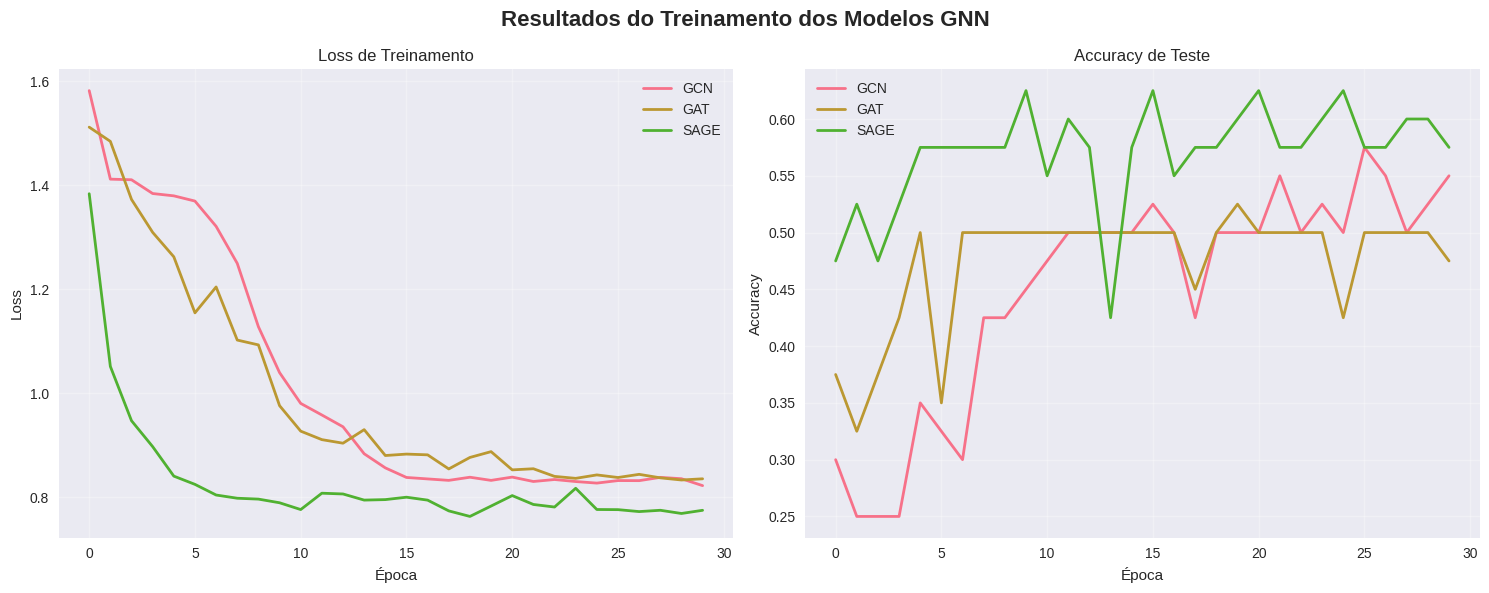


📊 RESULTADOS FINAIS:
GCN - Loss final: 0.8221, Accuracy final: 0.5500
GAT - Loss final: 0.8352, Accuracy final: 0.4750
SAGE - Loss final: 0.7746, Accuracy final: 0.5750

🏆 MELHOR MODELO: SAGE com accuracy de 0.5750


In [18]:
# Visualização dos Resultados
def plot_training_results(gcn_losses, gcn_accuracies, gat_losses, gat_accuracies, 
                         sage_losses, sage_accuracies):
    """Visualiza resultados do treinamento"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Resultados do Treinamento dos Modelos GNN', fontsize=16, fontweight='bold')
    
    # Plot 1: Loss
    axes[0].plot(gcn_losses, label='GCN', linewidth=2)
    axes[0].plot(gat_losses, label='GAT', linewidth=2)
    axes[0].plot(sage_losses, label='SAGE', linewidth=2)
    axes[0].set_title('Loss de Treinamento')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Accuracy
    axes[1].plot(gcn_accuracies, label='GCN', linewidth=2)
    axes[1].plot(gat_accuracies, label='GAT', linewidth=2)
    axes[1].plot(sage_accuracies, label='SAGE', linewidth=2)
    axes[1].set_title('Accuracy de Teste')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas finais
    print("\n📊 RESULTADOS FINAIS:")
    print(f"GCN - Loss final: {gcn_losses[-1]:.4f}, Accuracy final: {gcn_accuracies[-1]:.4f}")
    print(f"GAT - Loss final: {gat_losses[-1]:.4f}, Accuracy final: {gat_accuracies[-1]:.4f}")
    print(f"SAGE - Loss final: {sage_losses[-1]:.4f}, Accuracy final: {sage_accuracies[-1]:.4f}")
    
    # Melhor modelo
    final_accuracies = [gcn_accuracies[-1], gat_accuracies[-1], sage_accuracies[-1]]
    model_names = ['GCN', 'GAT', 'SAGE']
    best_model_idx = np.argmax(final_accuracies)
    
    print(f"\n🏆 MELHOR MODELO: {model_names[best_model_idx]} com accuracy de {final_accuracies[best_model_idx]:.4f}")

# Visualizar resultados
plot_training_results(gcn_losses, gcn_accuracies, gat_losses, gat_accuracies, 
                     sage_losses, sage_accuracies)


In [19]:
# Salvar Modelos e Resultados
def save_models_and_results(gcn_model, gat_model, sage_model, 
                          gcn_losses, gcn_accuracies, gat_losses, gat_accuracies,
                          sage_losses, sage_accuracies, filename='gnn_results.pkl'):
    """Salva modelos e resultados"""
    output_path = f'../data/{filename}'
    
    # Criar diretório se não existir
    os.makedirs('../data', exist_ok=True)
    
    # Preparar dados para salvar
    results = {
        'models': {
            'gcn': gcn_model.state_dict() if gcn_model else None,
            'gat': gat_model.state_dict() if gat_model else None,
            'sage': sage_model.state_dict() if sage_model else None
        },
        'training_history': {
            'gcn_losses': gcn_losses,
            'gcn_accuracies': gcn_accuracies,
            'gat_losses': gat_losses,
            'gat_accuracies': gat_accuracies,
            'sage_losses': sage_losses,
            'sage_accuracies': sage_accuracies
        },
        'timestamp': time.time()
    }
    
    # Salvar resultados
    with open(output_path, 'wb') as f:
        pickle.dump(results, f)
    
    print(f"Modelos e resultados salvos em: {output_path}")
    print(f"Tamanho do arquivo: {os.path.getsize(output_path) / (1024**2):.2f} MB")

# Salvar resultados
save_models_and_results(
    gcn_model if 'gcn_model' in locals() else None,
    gat_model if 'gat_model' in locals() else None,
    sage_model if 'sage_model' in locals() else None,
    gcn_losses, gcn_accuracies, gat_losses, gat_accuracies,
    sage_losses, sage_accuracies
)

print("\n✅ Implementação de GNNs concluída com sucesso!")
print("📁 Arquivos criados:")
print("  - ../data/gnn_results.pkl")
print("\n🎯 Próximos passos:")
print("  - Analise os resultados dos modelos")
print("  - Experimente com diferentes hiperparâmetros")
print("  - Implemente novos tipos de grafos de xadrez")
print("  - Explore interpretabilidade dos modelos")


Modelos e resultados salvos em: ../data/gnn_results.pkl
Tamanho do arquivo: 0.20 MB

✅ Implementação de GNNs concluída com sucesso!
📁 Arquivos criados:
  - ../data/gnn_results.pkl

🎯 Próximos passos:
  - Analise os resultados dos modelos
  - Experimente com diferentes hiperparâmetros
  - Implemente novos tipos de grafos de xadrez
  - Explore interpretabilidade dos modelos
